In [1]:
from trace_process_utils import *
from scipy.stats import pearsonr
from tqdm import tqdm
import cupy as cp
import numpy as np


mpl.rcParams['figure.dpi'] = 250
plt.rc('text', usetex=False)

from pprint import pprint

## Original traces

In [2]:
# trs_folder = "/mnt/jbod_main/public/qsp/trace_soc/"
# trs_full = "rpi3-atf-full.npz"
# trs_path = trs_folder + trs_full

# data_atf_full = np.load(trs_path)

# t_full = data_atf_full['time_base']
# trigger_trace_full = data_atf_full['channel_A']
# em_trace_full = data_atf_full['channel_B']

# print(t_full.shape)

In [3]:
trs_folder = "/mnt/jbod_main/public/qsp/trace_soc/"
trs_full = "rpi3-atf-full-3.csv"
trs_path = trs_folder + trs_full

data_atf_full = get_pico3203D_data_csv(trs_path)

t_full = data_atf_full[0, :]
trigger_trace_full = data_atf_full[1, :]
em_trace_full = data_atf_full[2, :]

print(t_full.shape)

['时间', '通道 A', '通道 B']
['(ms)', '(V)', '(mV)']
(15625004,)


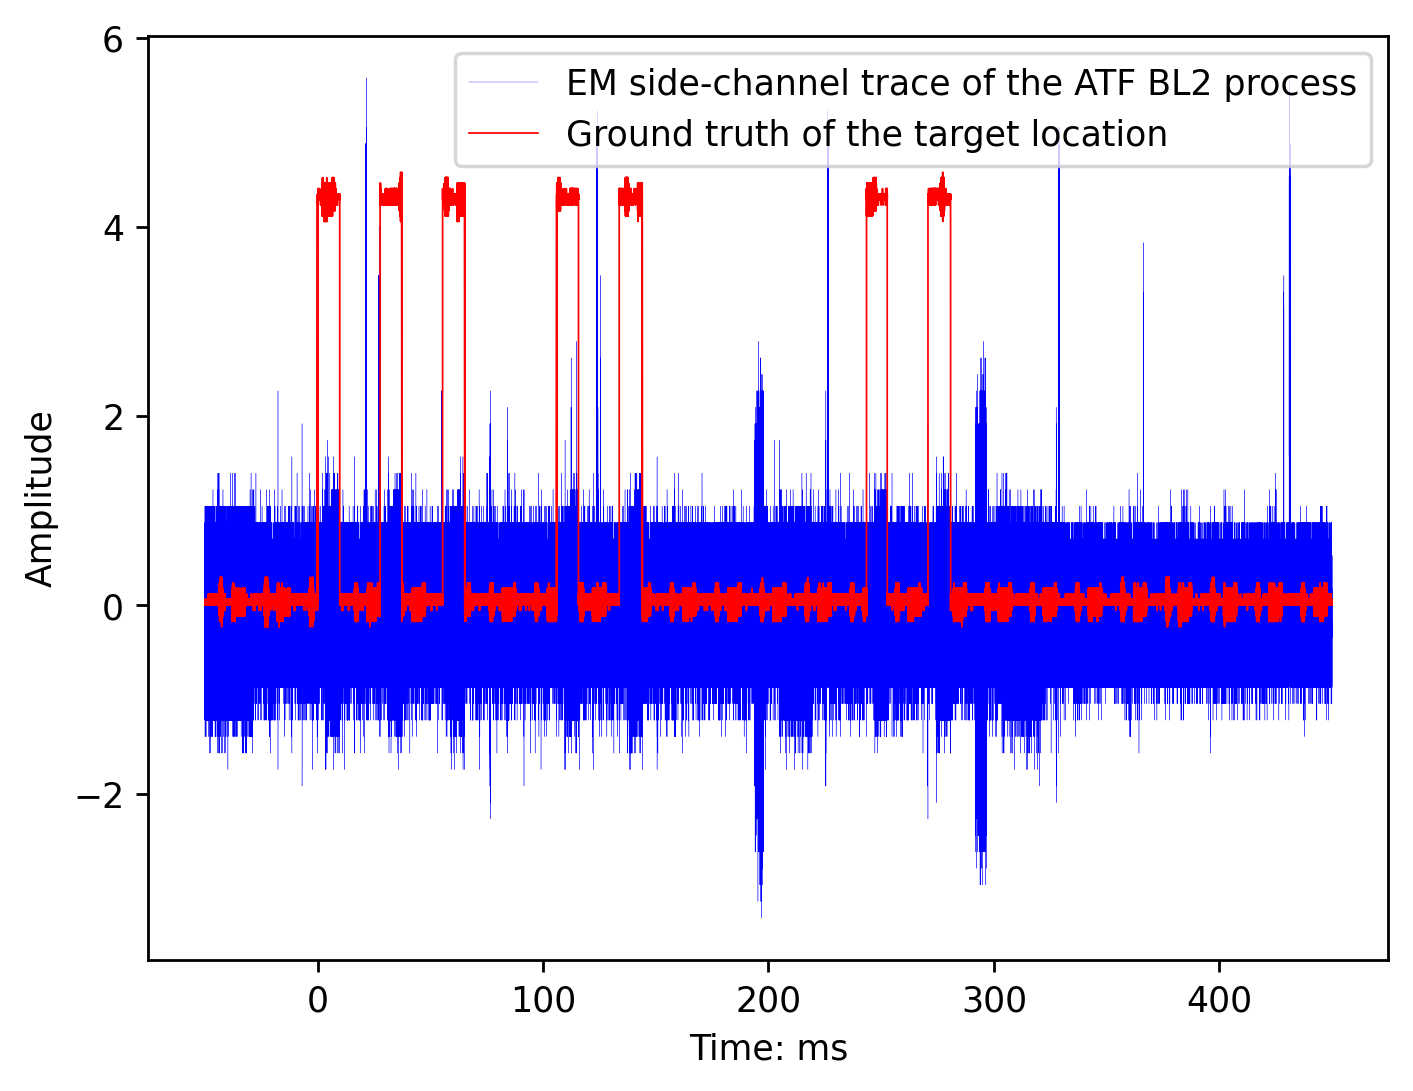

[ 1562486  1870228  2429827  2731561  3296132  3603555  4877796  5179610
  5744171  6063051  9172236  9459018 10023577 10337969]


In [4]:
plt.plot(t_full, em_trace_full, linewidth = 0.1, color="blue", label="EM side-channel trace of the ATF BL2 process")
plt.plot(t_full, trigger_trace_full*1.3, linewidth=0.5, color="red", label="Ground truth of the target location")
plt.legend(loc="upper right")
plt.ylabel("Amplitude")
plt.xlabel("Time: ms")

plt.savefig("atf-overall-trace-and-trigger.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

edges_full = get_trigger_edges_uniform(trigger_trace_full)
print(edges_full)

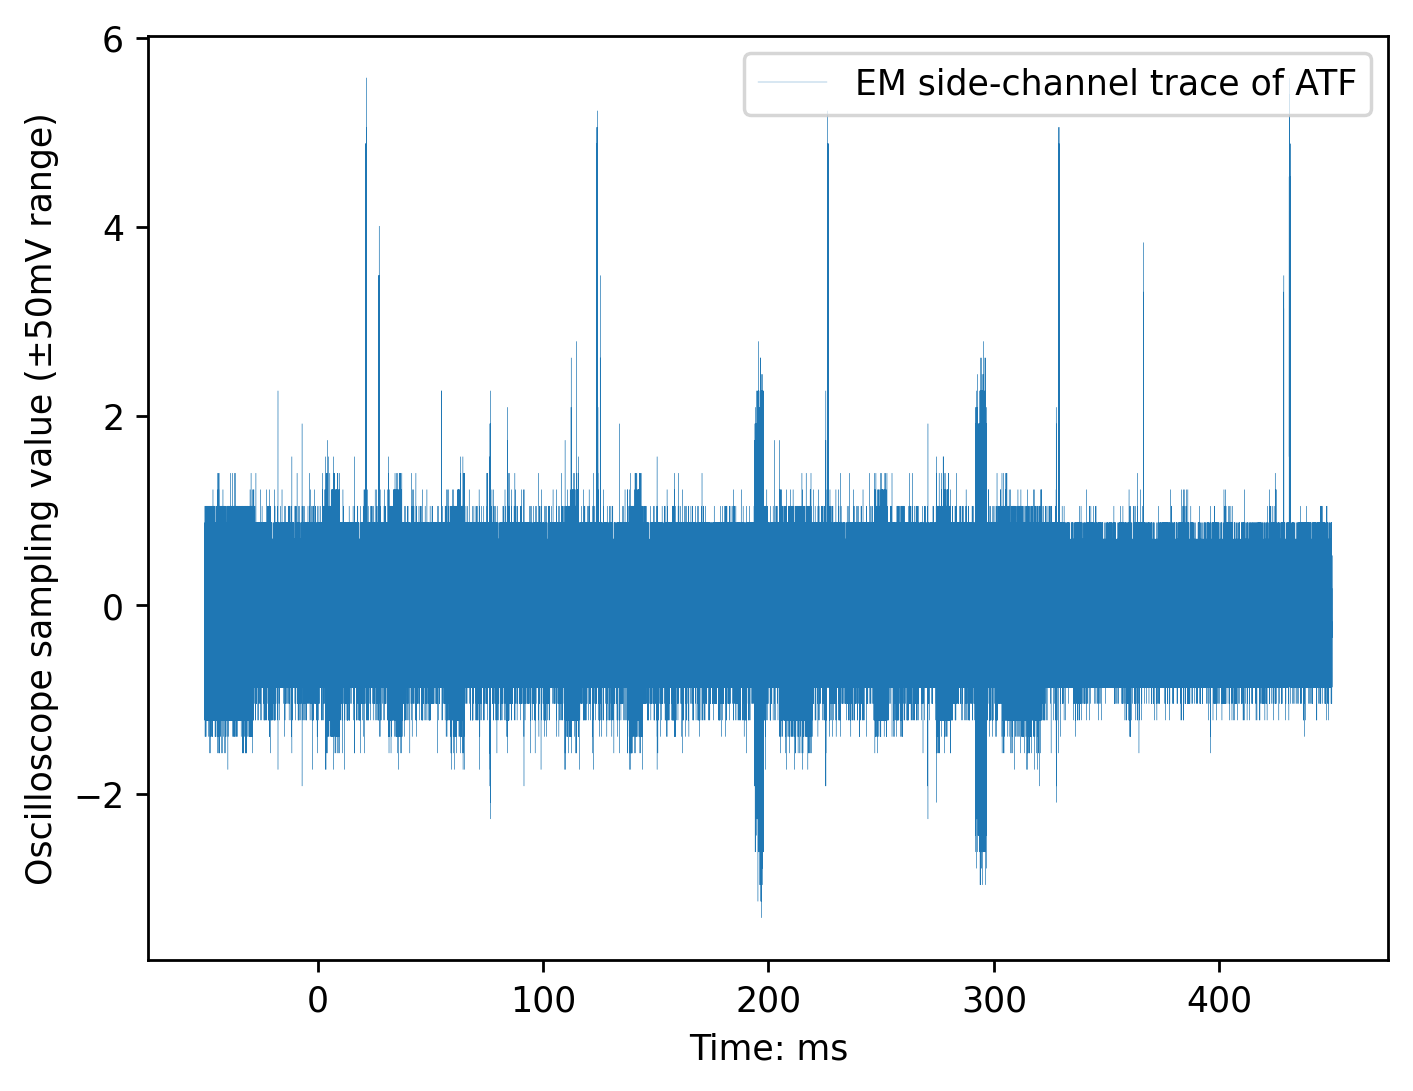

In [5]:
plt.plot(t_full, em_trace_full, linewidth = 0.1, label="EM side-channel trace of ATF")
plt.legend(loc="upper right")
plt.ylabel("Oscilloscope sampling value (±50mV range)")
plt.xlabel("Time: ms")
# plt.savefig("atf-overall-trace.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

['时间', '通道 A', '通道 B']
['(ms)', '(V)', '(mV)']
shape:  (625004,)


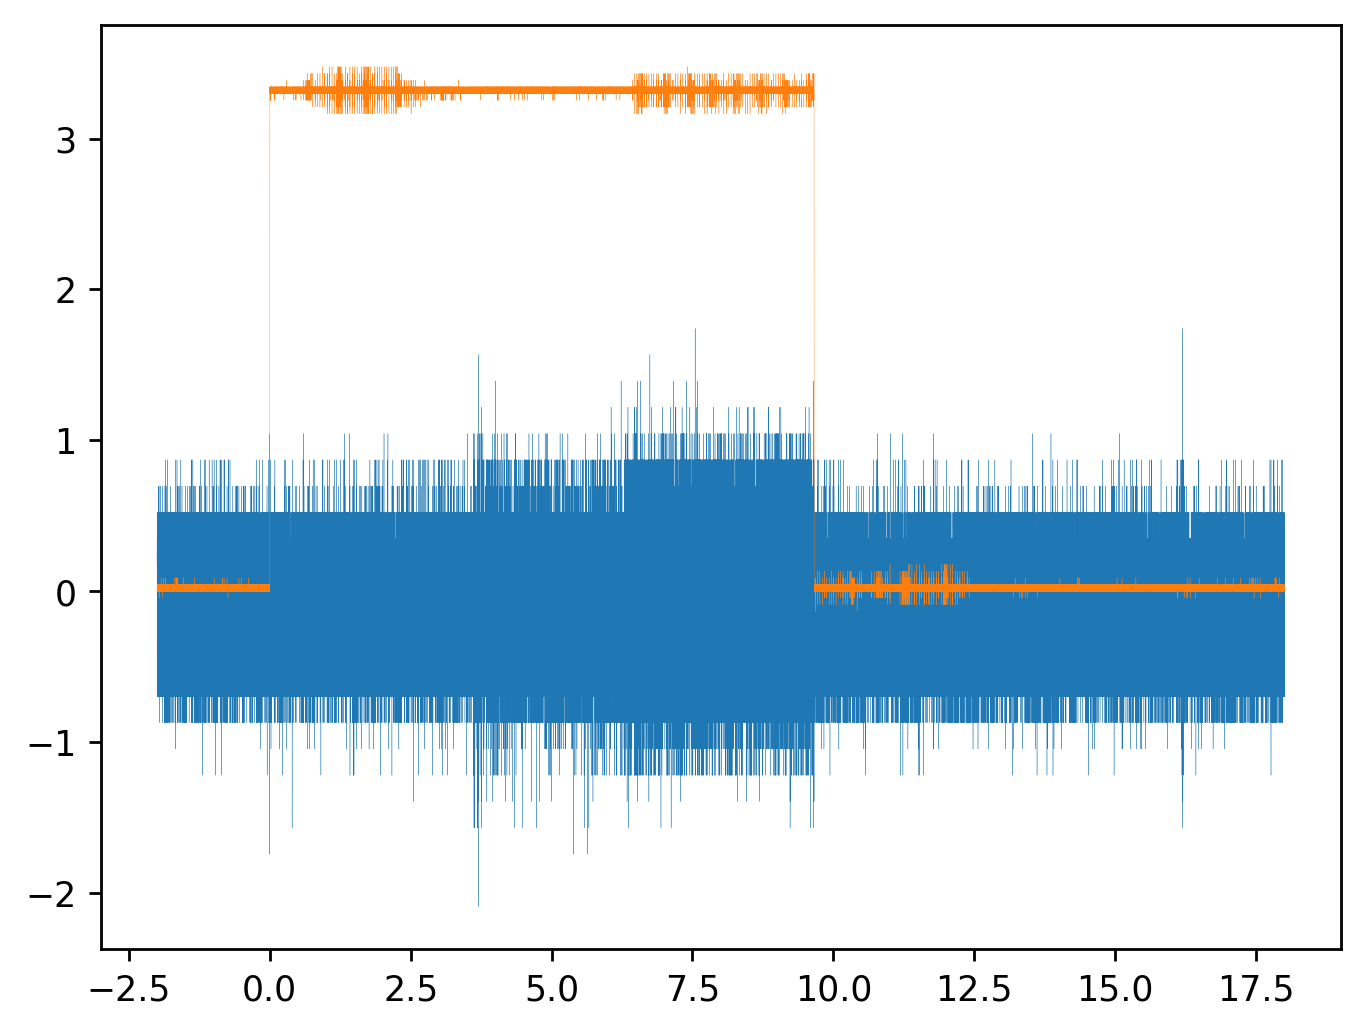

[ 62486 364283]


In [6]:
trs_folder = "/mnt/jbod_main/public/qsp/trace_soc/"
trs_target = "rpi3-atf-template_3-3.csv" 
# trs_target = "rpi3-atf-template_1-3.csv" # sofar the best
# trs_target = "rpi3-atf-template_4-3.csv"

trs_path = trs_folder + trs_target

data_atf_target = get_pico3203D_data_csv(trs_path)

t_target = data_atf_target[0, :]
trigger_trace_target = data_atf_target[1, :]
em_trace_target = data_atf_target[2, :]

print("shape: ", t_target.shape)

plt.plot(t_target, em_trace_target, linewidth = 0.1)
plt.plot(t_target, trigger_trace_target, linewidth=0.1)
plt.show()

edges_target = get_trigger_edges_uniform(trigger_trace_target)
print(edges_target)

In [7]:
# plt.plot(t_target[:159771+31236], em_trace_target[:159771+31236], linewidth = 0.1, label="EM side-channel trace of RSA2048 verify in ATF")
# plt.plot(t_target[:159771+31236], trigger_trace_target[:159771+31236], linewidth=0.5, label="Trigger output")
# plt.legend(loc="upper right")
# plt.ylabel("Oscilloscope sampling value (±50mV range)")
# plt.xlabel("Time: ms")
# plt.savefig("atf-rsa-trace.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)
# plt.show()

In [8]:
# B= em_trace_target[edges_target[-2]:edges_target[-1]]
# A= em_trace_full[edges_full[-2]:edges_full[-1]]
# em_trace_target[edges_target[-2]:edges_target[-1]] = em_trace_full[edges_full[-2]:edges_full[-2]+B.shape[0]]

301797 314392


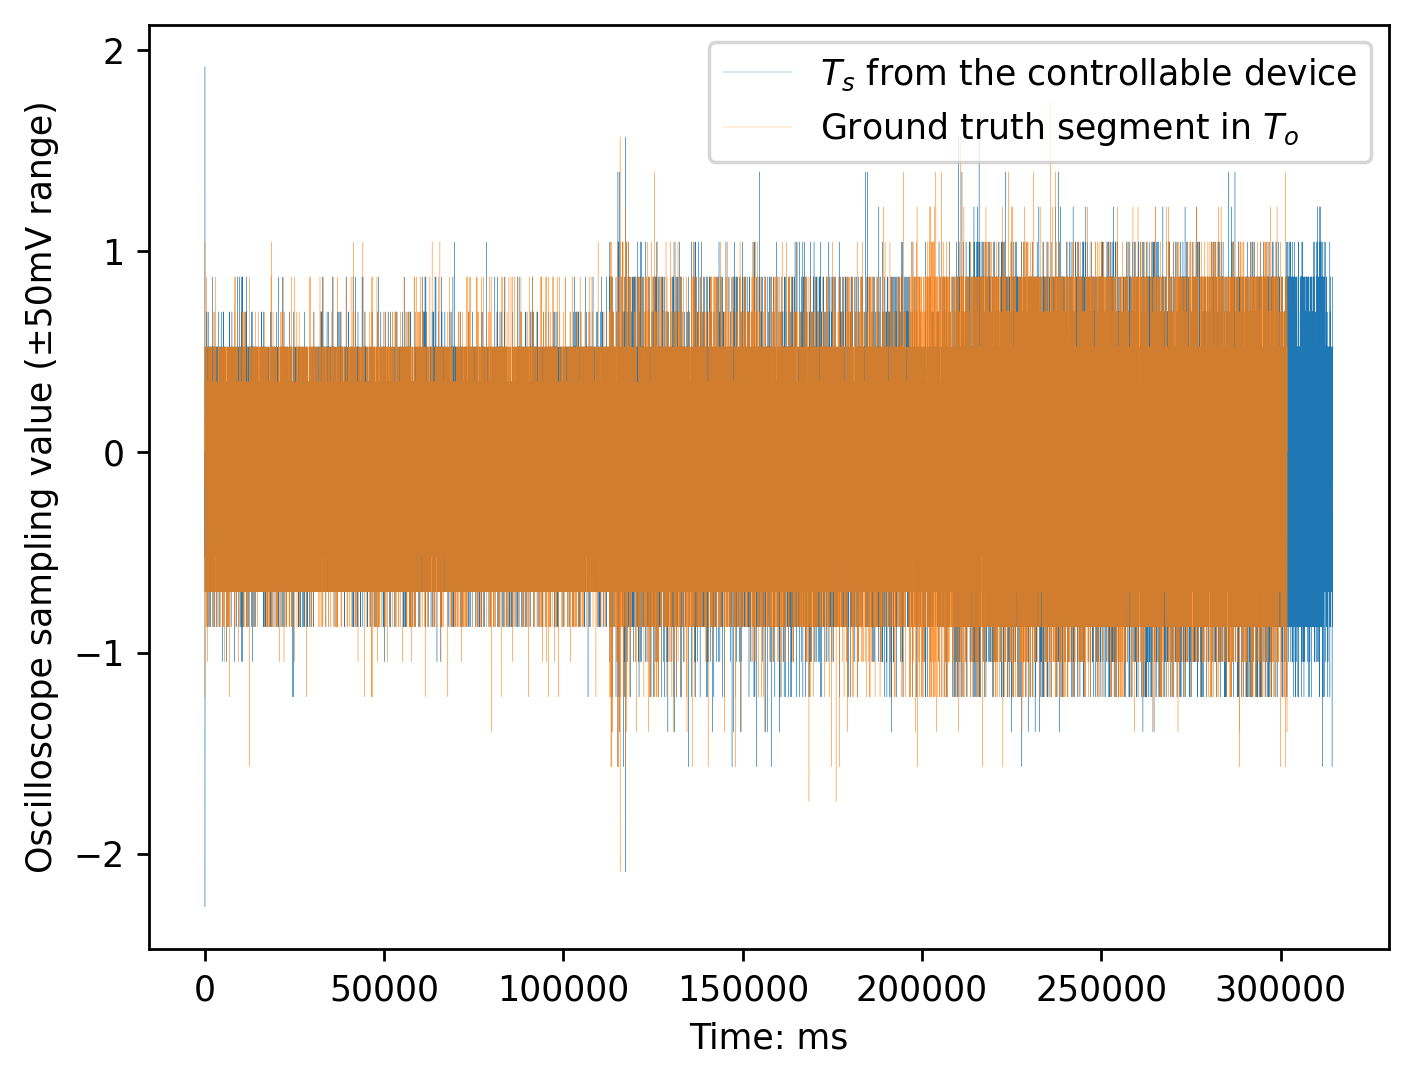

In [9]:
B= em_trace_target[edges_target[-2]:edges_target[-1]]
A= em_trace_full[edges_full[-2]:edges_full[-1]]

print(B.shape[0], A.shape[0])


plt.plot(A, linewidth=0.1, label=r"$T_{s}$ from the controllable device")
plt.plot(B, linewidth=0.1, alpha=0.8, label=r"Ground truth segment in $T_{o}$")
plt.ylabel("Oscilloscope sampling value (±50mV range)")
plt.xlabel("Time: ms")
plt.legend(loc="upper right")
# plt.savefig("atf-rsa-trace-compare.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

5208334 100599
num_blocks: 19953
159871 0.14612992
986795 27475.74


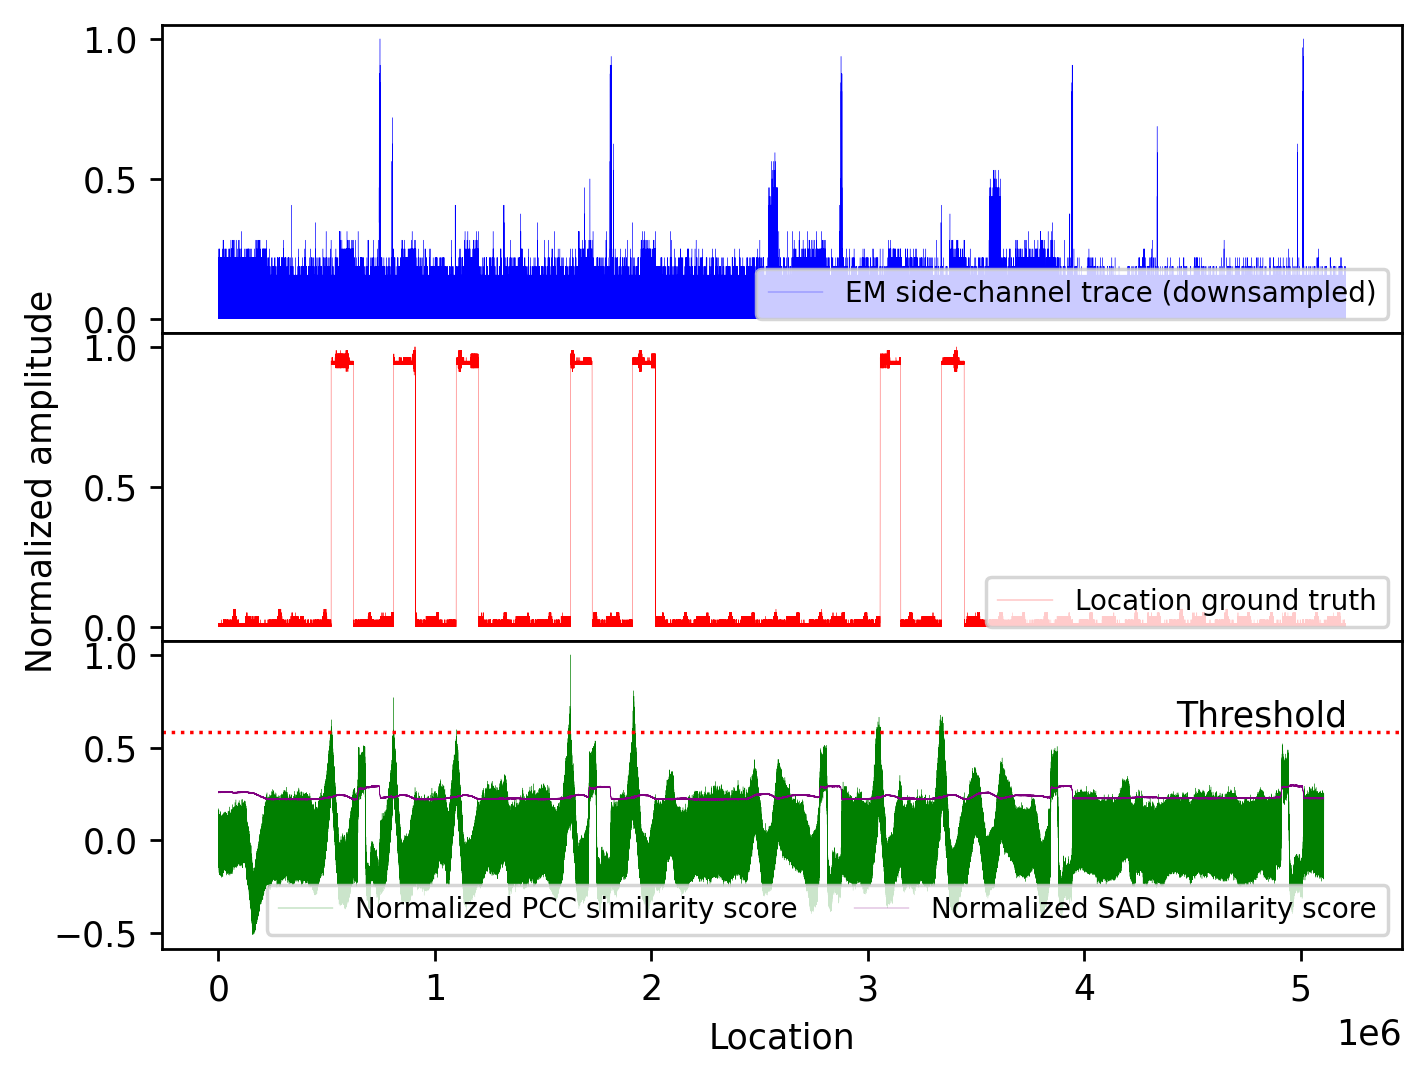

In [16]:
def similar_index_freq(x1, y1, x2, y2):
    if len(x1)<len(x2):
        x1, y1, x2, y2 = x2, y2, x1, y1
    y2_new = np.interp(x1*(x2[-1]/x1[-1]), x2, y2)
    score, pvalue = pearsonr(y1, y2_new)
    return score

def similar_index_freq_sad(x1, y1, x2, y2):
    if len(x1)<len(x2):
        x1, y1, x2, y2 = x2, y2, x1, y1
    y2_new = np.interp(x1*(x2[-1]/x1[-1]), x2, y2)
    score = np.sum(np.abs(y1-y2_new)/len(x1))
    return score

def similar_index_time(x1, y1, x2, y2):
    if len(x1)<len(x2):
        x1, y1, x2, y2 = x2, y2, x1, y1
    y2_new = np.interp(x1*(x2[-1]/x1[-1]), x2, y2)
    score, pvalue = pearsonr(y1, y2_new)
    return score

def sliding_sad(A, B):
    M = A.shape[0]
    windows = cp.lib.stride_tricks.sliding_window_view(B, window_shape=M)
    sad = cp.sum(cp.abs(windows - A), axis=1)
    return sad

def sliding_pearson(A, B):
    M = A.shape[0]
    windows = cp.lib.stride_tricks.sliding_window_view(B, window_shape=M)
    A_mean = cp.mean(A)
    A_std = cp.std(A)
    windows_mean = cp.mean(windows, axis=1)
    windows_std = cp.std(windows, axis=1)
    cov = cp.sum((A - A_mean) * (windows - windows_mean[:, None]), axis=1)
    pearson = cov / (M * A_std * windows_std)
    return pearson
pearson_kernel = cp.RawKernel(r'''
extern "C" __global__
void pearson_correlation(const float *A, const float *B, float *results, int A_size, int B_size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int num_windows = B_size - A_size + 1;

    if (idx < num_windows) {
        float sum_A = 0.0, sum_B = 0.0, sum_AB = 0.0;
        float sum_A2 = 0.0, sum_B2 = 0.0;

        for (int i = 0; i < A_size; i++) {
            float a = A[i];
            float b = B[idx + i];
            sum_A += a;
            sum_B += b;
            sum_AB += a * b;
            sum_A2 += a * a;
            sum_B2 += b * b;
        }

        float mean_A = sum_A / A_size;
        float mean_B = sum_B / A_size;
        float std_A = sqrt(sum_A2 / A_size - mean_A * mean_A);
        float std_B = sqrt(sum_B2 / A_size - mean_B * mean_B);

        if (std_A > 1e-6 && std_B > 1e-6) {
            results[idx] = (sum_AB / A_size - mean_A * mean_B) / (std_A * std_B);
        } else {
            results[idx] = -1.0;
        }
    }
}
''', 'pearson_correlation')

def pearson_correlation_single_gpu(A, B):
    M = A.shape[0]
    N = B.shape[0]
    print(N, M)
    num_windows = N - M + 1

    A_gpu = cp.array(A, dtype=cp.float32)
    B_gpu = cp.array(B, dtype=cp.float32)

    results_gpu = cp.zeros(num_windows, dtype=cp.float32)

    threads_per_block = 256
    num_blocks = (num_windows + threads_per_block - 1) // threads_per_block
    print(f"num_blocks: {num_blocks}")
    pearson_kernel((num_blocks,), (threads_per_block,), (A_gpu, B_gpu, results_gpu, M, N))

    results = results_gpu.get()

    best_index = int(np.argmin(results))

    return best_index, results

sad_kernel = cp.RawKernel(r'''
extern "C" __global__
void sad_similarity(const float *A, const float *B, float *results, int A_size, int B_size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int num_windows = B_size - A_size + 1;

    if (idx < num_windows) {
        float sad_value = 0.0;

        for (int i = 0; i < A_size; i++) {
            sad_value += fabsf(A[i] - B[idx + i]);
        }

        results[idx] = sad_value;
    }
}
''', 'sad_similarity')

def sad_similarity_single_gpu(A, B):
    M = A.shape[0]
    N = B.shape[0]
    num_windows = N - M + 1

    A_gpu = cp.array(A, dtype=cp.float32)
    B_gpu = cp.array(B, dtype=cp.float32)

    results_gpu = cp.zeros(num_windows, dtype=cp.float32)

    threads_per_block = 256
    num_blocks = (num_windows + threads_per_block - 1) // threads_per_block

    sad_kernel((num_blocks,), (threads_per_block,), (A_gpu, B_gpu, results_gpu, M, N))

    results = results_gpu.get()

    best_index = int(np.argmin(results))

    return best_index, results

def downsample_average(signal, factor):
    N = len(signal)
    num_samples = N // factor
    downsampled_signal = np.max(np.abs(signal[:num_samples * factor].reshape(-1, factor)), axis=1)
    return downsampled_signal

DS = True
if DS:
    downsample_factor = 3
    A = downsample_average(em_trace_target[edges_target[-2]:edges_target[-1]], downsample_factor)
    B = downsample_average(em_trace_full, downsample_factor)
    C = downsample_average(trigger_trace_full, downsample_factor)
else:
    downsample_factor = 1
    A = np.abs(em_trace_target[edges_target[-2]:edges_target[-1]])
    B = np.abs(em_trace_full)
    C = np.abs(trigger_trace_full)

best_index_pcc, results_pcc = pearson_correlation_single_gpu(A, B)
best_index_sad, results_sad = sad_similarity_single_gpu(A, B)

print(best_index_pcc, np.max(results_pcc))
print(best_index_sad, np.max(results_sad))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, 
                                    gridspec_kw={'hspace': 0})
if DS:
    ax1.plot(B/np.max(B), color='blue', linewidth=0.1, label="EM side-channel trace (downsampled)")
else:
    ax1.plot(em_trace_full/np.max(em_trace_full), color='blue', linewidth=0.1, label="EM side-channel trace")
ax1.legend(loc="lower right",  prop={'size': 8})
ax2.plot(C/np.max(C), color='red', linewidth=0.1, label="Location ground truth")
ax2.legend(loc="lower right",  prop={'size': 8})
ax3.plot(results_pcc/np.max(results_pcc), color='green', linewidth=0.1, label="Normalized PCC similarity score")
ax3.plot(0.3*results_sad/np.max(results_sad), color='purple', linewidth=0.1, label="Normalized SAD similarity score")
if DS:
    y_line = 0.585
    ax3.axhline(y=y_line, color='r', linestyle=":", linewidth=1)
    x_min, x_max = ax3.get_xlim()
    ax3.text((x_min + x_max)*0.85, y_line + 0.03, 'Threshold')
    ax3.set_xlabel('Location')
else:
    y_line = 0.85
    ax3.axhline(y=y_line, color='r', linestyle=":", linewidth=1)
    x_min, x_max = ax3.get_xlim()
    ax3.text((x_min + x_max)*0.85, y_line + 0.03, 'Threshold')
    ax3.set_xlabel('Location')


ax3.legend(loc="lower right", ncol=2, prop={'size': 8})
fig.text(0.05, 0.5, 'Normalized amplitude', va='center', ha='center', rotation='vertical')

if DS:
    plt.savefig("atf-sim-result-downsample.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)
else:
    plt.savefig("atf-sim-result.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

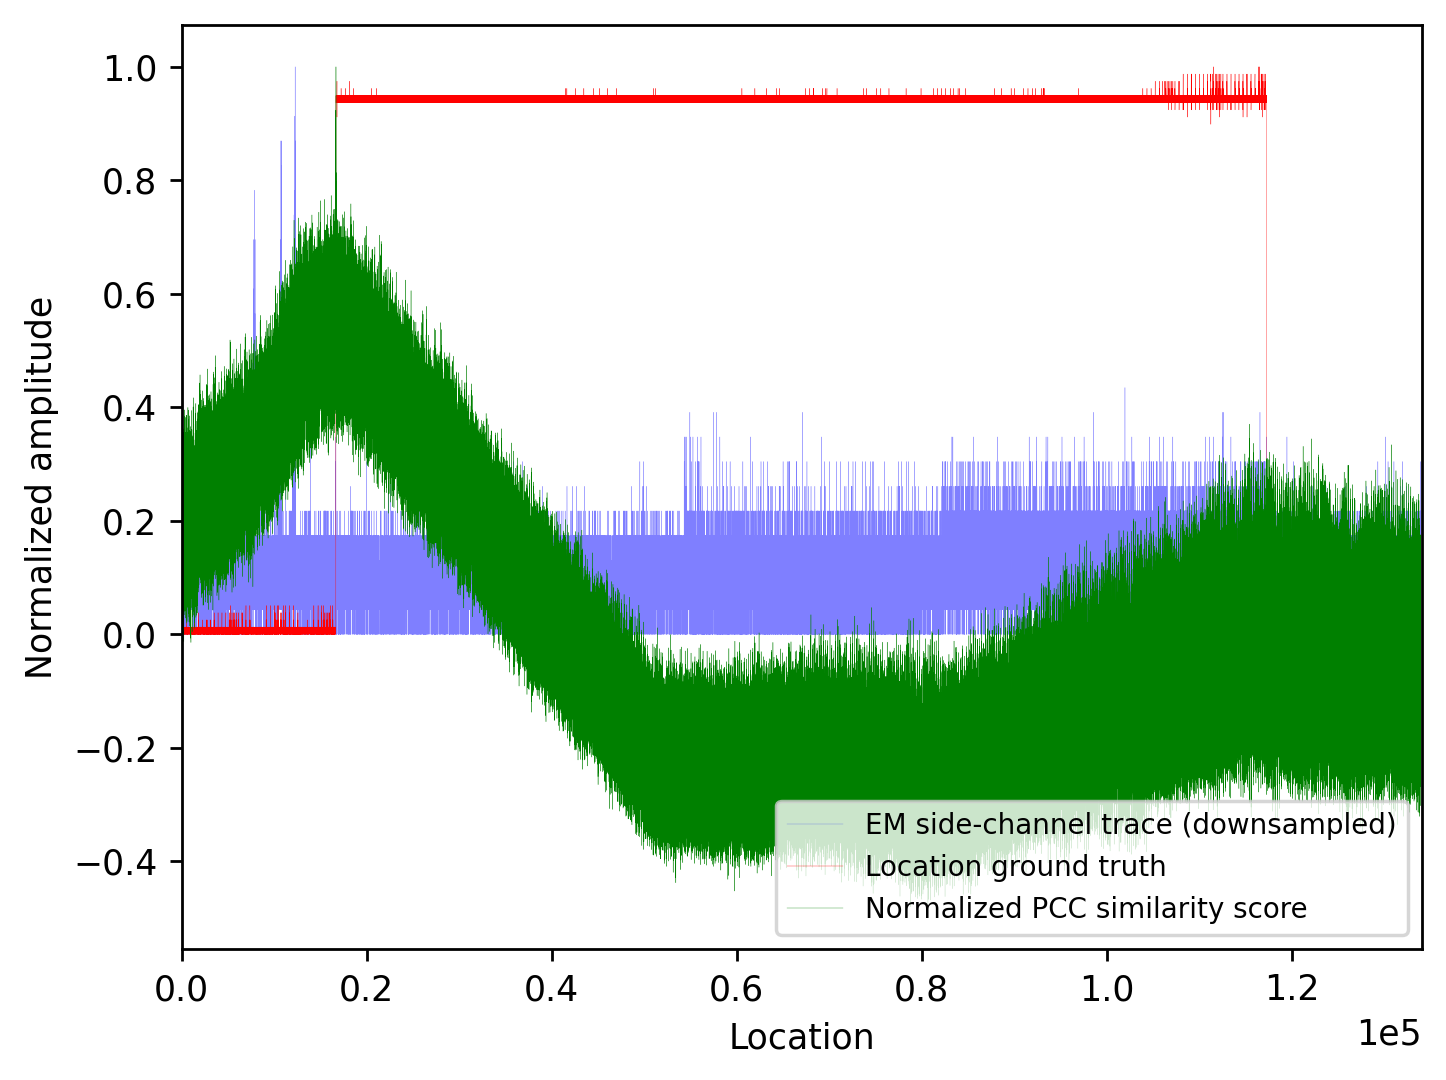

In [67]:
# second target
zoom_start = int(edges_full[2]-0.05e6) // downsample_factor
zoom_end = int(edges_full[3]+0.05e6) // downsample_factor
fig, ax = plt.subplots()
# ax.plot(em_trace_full[zoom_start:zoom_end]/np.max(em_trace_full[zoom_start:zoom_end]), color='blue', linewidth=0.1, label="EM side-channel trace", alpha=0.5)
ax.plot(B[zoom_start:zoom_end]/np.max(B[zoom_start:zoom_end]), color='blue', linewidth=0.1, label="EM side-channel trace (downsampled)", alpha=0.5)
ax.plot(C[zoom_start:zoom_end]/np.max(C[zoom_start:zoom_end]), color='red', linewidth=0.1, label="Location ground truth")
ax.plot(results_pcc[zoom_start:zoom_end]/np.max(results_pcc[zoom_start:zoom_end]), color='green', linewidth=0.1, label="Normalized PCC similarity score")
ax.ticklabel_format(style='sci', scilimits=(-5,5), axis='x')
ax.set_xlabel("Location")
ax.set_ylabel("Normalized amplitude")
ax.set_xlim((0, 1.34e5))
ax.legend(loc="lower right", prop={'size': 8})
plt.savefig("atf-pcc-result-zoomed-in-downsample.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

In [14]:
# zoom_start = int(edges_full[0]-0.05e6)
# zoom_end = int(edges_full[1]+0.05e6)
# plt.plot(em_trace_full[zoom_start:zoom_end]/np.max(em_trace_full[zoom_start:zoom_end]), color='blue', linewidth=0.1, label="EM side-channel trace", alpha=0.5)
# plt.plot(C[zoom_start:zoom_end]/np.max(C[zoom_start:zoom_end]), color='red', linewidth=0.1, label="Location ground truth")
# plt.plot(results_sad[zoom_start:zoom_end]/np.max(results_sad[zoom_start:zoom_end]), color='green', linewidth=0.1, label="Normalized PCC similarity score")
# plt.xlabel("Time")
# plt.ylabel("Normalized amplitude")
# plt.legend(loc="lower right", prop={'size': 8})
# # plt.savefig("atf-pcc-result-zoomed-in.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0.1)

# plt.show()